# Import Libraries

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from model import Model_BN
%matplotlib inline

In [2]:
CLASS_NAMES= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Data Statistics

In [3]:
simple_transforms = transforms.Compose([transforms.ToTensor()])
exp_train = datasets.CIFAR10('./data', train=True, download=True)
exp_test = datasets.CIFAR10('./data', train=True, download=False)
exp_train_data = exp_train.data
exp_test_data = exp_test.data
exp_data = np.concatenate((exp_train_data, exp_test_data), axis=0)

print(f'Shape: {exp_data.shape}')
print(f'Mean: {exp_data.mean(axis=(0,1,2))/255}')
print(f'STD: {exp_data.std(axis=(0,1,2))/255}')

Files already downloaded and verified
Shape: (100000, 32, 32, 3)
Mean: [0.49139968 0.48215841 0.44653091]
STD: [0.24703223 0.24348513 0.26158784]


# Initialize train and test transforms

In [4]:
# Training transform
train_transforms = transforms.Compose([transforms.RandomApply([transforms.RandAugment()], p=0.3),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])])

# Test transform
test_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])])

# transform to inverse effect of Normalization while ploting
inv_transform = transforms.Normalize([-0.49139968/0.24703223, -0.48215841/0.24348513, -0.44653091/0.26158784], [1/0.24703223, 1/0.24348513, 1/0.26158784])

# Download data

In [5]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


# Create data loader

In [6]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Plot data

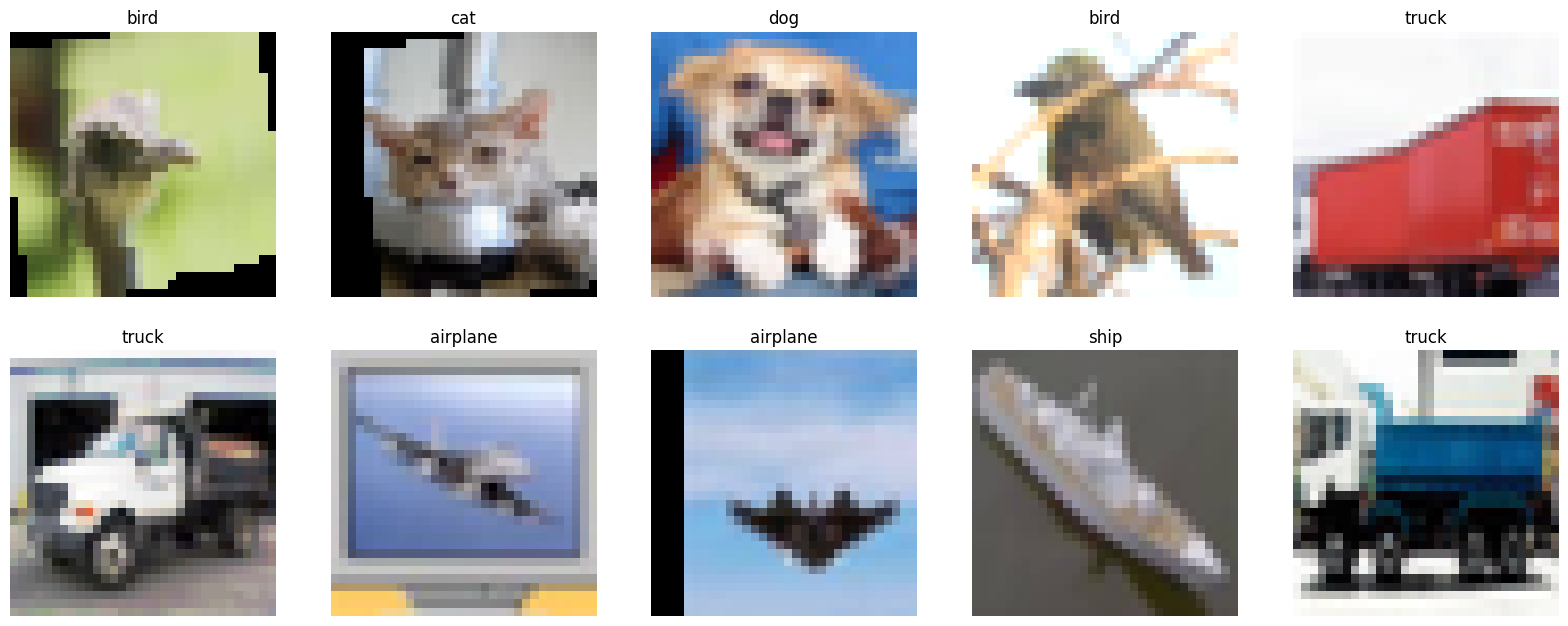

In [7]:
figure = plt.figure(figsize=(20,20))
num_of_images = 10
images, labels = next(iter(train_loader))
images = inv_transform(images)
for index in range(1, num_of_images + 1):
    plt.subplot(5, 5, index)
    plt.title(CLASS_NAMES[labels[index].numpy()])
    plt.axis('off')
    plt.imshow(np.transpose(images[index], (1, 2, 0)))

In [9]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Model_BN().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]           2,304
       BatchNorm2d-6           [-1, 16, 32, 32]              32
              ReLU-7           [-1, 16, 32, 32]               0
           Dropout-8           [-1, 16, 32, 32]               0
            Conv2d-9            [-1, 8, 32, 32]             128
        MaxPool2d-10            [-1, 8, 16, 16]               0
           Conv2d-11           [-1, 16, 16, 16]           1,152
      BatchNorm2d-12           [-1, 16, 16, 16]              32
             ReLU-13           [-1, 16, 16, 16]               0
          Dropout-14           [-1

In [10]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)

    train_loss = 0
    correct = 0
    processed = 0

    for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)

        # Calculate loss
        loss = F.nll_loss(y_pred, target)
        train_loss += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

    train_acc.append(100*correct/processed)
    train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [11]:
model =  Model_BN().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1, verbose=True)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


EPOCH: 0


Loss=1.4601223468780518 Batch_id=390 Accuracy=35.60: 100%|██████████| 391/391 [00:30<00:00, 13.02it/s]



Test set: Average loss: 1.5494, Accuracy: 4300/10000 (43.00%)

EPOCH: 1


Loss=1.4462015628814697 Batch_id=390 Accuracy=49.82: 100%|██████████| 391/391 [00:26<00:00, 14.95it/s]



Test set: Average loss: 1.2917, Accuracy: 5278/10000 (52.78%)

EPOCH: 2


Loss=1.3605972528457642 Batch_id=390 Accuracy=55.85: 100%|██████████| 391/391 [00:23<00:00, 16.50it/s]



Test set: Average loss: 1.3103, Accuracy: 5270/10000 (52.70%)

EPOCH: 3


Loss=1.3126499652862549 Batch_id=390 Accuracy=58.95: 100%|██████████| 391/391 [00:23<00:00, 16.34it/s]



Test set: Average loss: 1.0585, Accuracy: 6175/10000 (61.75%)

EPOCH: 4


Loss=1.0480945110321045 Batch_id=390 Accuracy=61.02: 100%|██████████| 391/391 [00:24<00:00, 15.75it/s]



Test set: Average loss: 1.1786, Accuracy: 5807/10000 (58.07%)

EPOCH: 5


Loss=0.9517579078674316 Batch_id=390 Accuracy=62.91: 100%|██████████| 391/391 [00:23<00:00, 16.43it/s]



Test set: Average loss: 1.0085, Accuracy: 6440/10000 (64.40%)

EPOCH: 6


Loss=0.9182984232902527 Batch_id=390 Accuracy=64.15: 100%|██████████| 391/391 [00:24<00:00, 15.73it/s]



Test set: Average loss: 1.0718, Accuracy: 6208/10000 (62.08%)

EPOCH: 7


Loss=1.0985305309295654 Batch_id=390 Accuracy=65.09: 100%|██████████| 391/391 [00:23<00:00, 16.37it/s]



Test set: Average loss: 1.0642, Accuracy: 6248/10000 (62.48%)

EPOCH: 8


Loss=0.9252877235412598 Batch_id=390 Accuracy=66.01: 100%|██████████| 391/391 [00:24<00:00, 16.20it/s]



Test set: Average loss: 1.1455, Accuracy: 6148/10000 (61.48%)

EPOCH: 9


Loss=0.9384716749191284 Batch_id=390 Accuracy=66.54: 100%|██████████| 391/391 [00:24<00:00, 16.17it/s]



Test set: Average loss: 0.9439, Accuracy: 6656/10000 (66.56%)

EPOCH: 10


Loss=0.8629658818244934 Batch_id=390 Accuracy=68.72: 100%|██████████| 391/391 [00:23<00:00, 16.43it/s]



Test set: Average loss: 0.8696, Accuracy: 6945/10000 (69.45%)

EPOCH: 11


Loss=0.8645932078361511 Batch_id=390 Accuracy=69.07: 100%|██████████| 391/391 [00:23<00:00, 16.70it/s]



Test set: Average loss: 0.8446, Accuracy: 6975/10000 (69.75%)

EPOCH: 12


Loss=0.9996258020401001 Batch_id=390 Accuracy=69.40: 100%|██████████| 391/391 [00:23<00:00, 16.73it/s]



Test set: Average loss: 0.8476, Accuracy: 7002/10000 (70.02%)

EPOCH: 13


Loss=0.754718005657196 Batch_id=390 Accuracy=69.61: 100%|██████████| 391/391 [00:23<00:00, 16.40it/s]



Test set: Average loss: 0.8532, Accuracy: 6955/10000 (69.55%)

EPOCH: 14


Loss=0.8838637471199036 Batch_id=390 Accuracy=69.74: 100%|██████████| 391/391 [00:24<00:00, 15.76it/s]



Test set: Average loss: 0.8520, Accuracy: 6958/10000 (69.58%)

EPOCH: 15


Loss=0.7500531077384949 Batch_id=390 Accuracy=69.74: 100%|██████████| 391/391 [00:24<00:00, 15.91it/s]



Test set: Average loss: 0.8566, Accuracy: 6945/10000 (69.45%)

EPOCH: 16


Loss=0.7874142527580261 Batch_id=390 Accuracy=70.02: 100%|██████████| 391/391 [00:23<00:00, 16.37it/s]



Test set: Average loss: 0.8315, Accuracy: 7021/10000 (70.21%)

EPOCH: 17


Loss=0.8535106778144836 Batch_id=390 Accuracy=69.99: 100%|██████████| 391/391 [00:25<00:00, 15.48it/s]



Test set: Average loss: 0.8606, Accuracy: 6941/10000 (69.41%)

EPOCH: 18


Loss=0.9126793742179871 Batch_id=390 Accuracy=70.09: 100%|██████████| 391/391 [00:23<00:00, 16.29it/s]



Test set: Average loss: 0.8614, Accuracy: 6939/10000 (69.39%)

EPOCH: 19


Loss=0.6925517320632935 Batch_id=390 Accuracy=70.00: 100%|██████████| 391/391 [00:24<00:00, 16.00it/s]



Test set: Average loss: 0.8515, Accuracy: 6981/10000 (69.81%)



Text(0.5, 1.0, 'Test Accuracy')

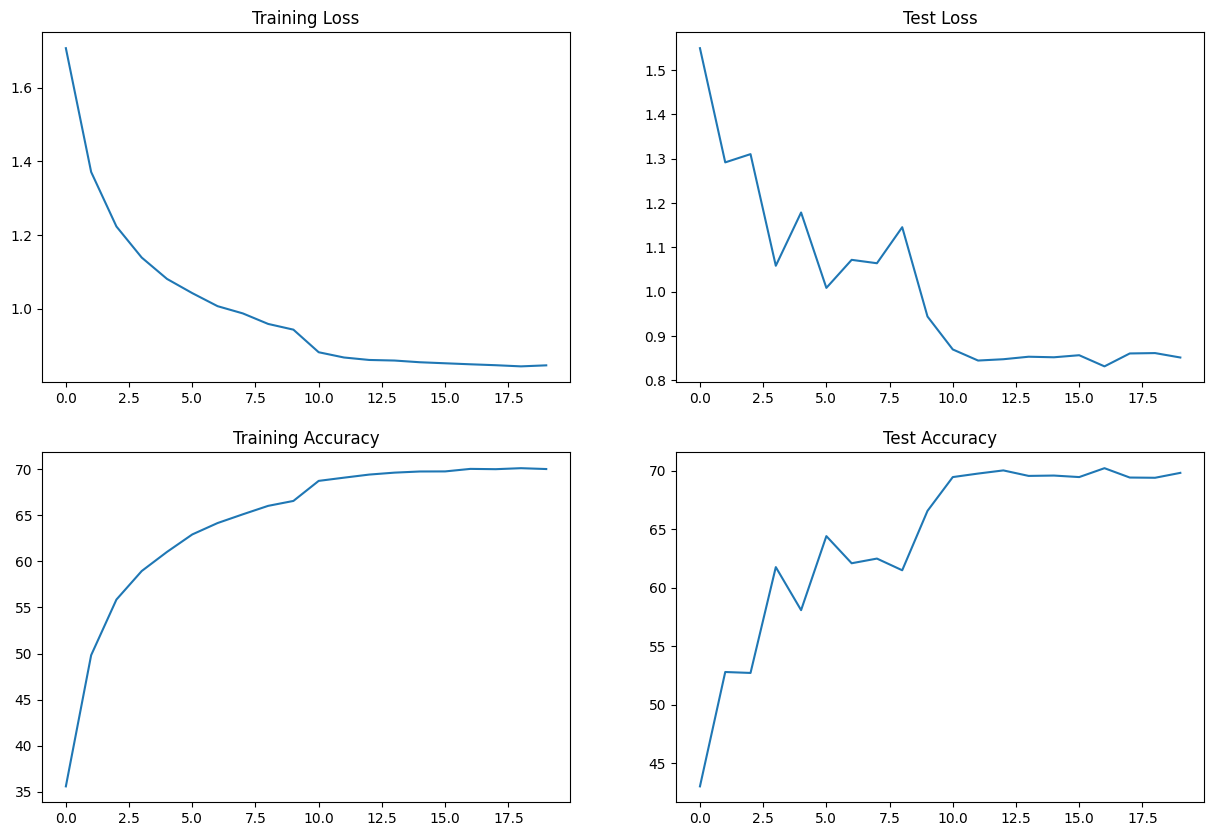

In [12]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [13]:
def plot_missclassified_images(model, test_loader):
  model.eval()

  missclassified_image_list = []
  label_list = []
  pred_list = []

  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      pred = output.argmax(dim=1, keepdim=True)
      if len(missclassified_image_list) > 10:
        break
      for i in range(len(pred)):
        if pred[i] != target[i]:
          missclassified_image_list.append(data[i])
          label_list.append(CLASS_NAMES[target[i]])
          pred_list.append(CLASS_NAMES[pred[i]])

  figure = plt.figure(figsize=(20,20))
  num_of_images = 10
  for index in range(1, num_of_images + 1):
      plt.subplot(5, 5, index)
      plt.title(f'Actual: {label_list[index]} Prediction: {pred_list[index]}')
      plt.axis('off')
      image = inv_transform(missclassified_image_list[index])
      plt.imshow(np.transpose(image.cpu(), (1, 2, 0)))

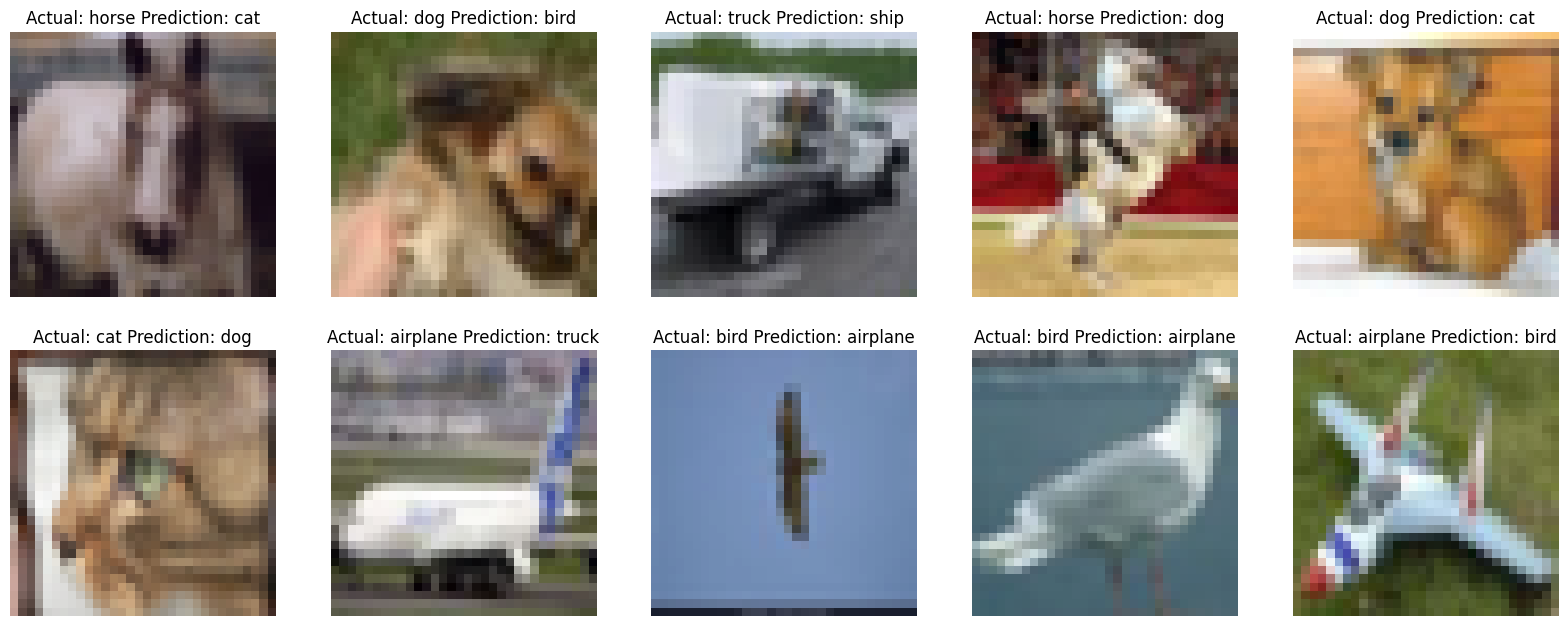

In [14]:
plot_missclassified_images(model, test_loader)